In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn import metrics

import holisticai
from holisticai.bias.mitigation.postprocessing import CalibratedEqualizedOdds, RejectOptionClassification

<h4> Data Loading and Baseline Modeling

Data Loading

In [3]:
# baseline_preprocessed_df = pd.read_csv("C:/Users/athar/OneDrive/Desktop/Rutgers/Ethical Stat Learning/Project/data/data_preprocessed_baseline.csv",index_col=0)
# baseline_preprocessed_df = baseline_preprocessed_df.drop(['id','age_cat'],axis=1)

In [3]:
baseline_preprocessed_df = pd.read_csv("../../data/data_baseline.csv",index_col=0)
baseline_preprocessed_df.head()
baseline_preprocessed_df = baseline_preprocessed_df.drop(['Asian_race','Hispanic_race','Other_race','High_score_text','High_v_score_text','Low_score_text','Native American_race'],axis=1)

In [4]:
protected_variables = ["sex", "African-American_race"]
output_variable = ["two_year_recid"]

group = ["African-American_race"]
group_a = baseline_preprocessed_df["African-American_race"] == 1
group_b = baseline_preprocessed_df["African-American_race"] == 0

In [5]:
y = baseline_preprocessed_df[output_variable]
X = pd.get_dummies(baseline_preprocessed_df.drop(output_variable, axis=1))
data_ = [X, y, group_a, group_b]

In [6]:
dataset = train_test_split(*data_, test_size=0.2, shuffle=True,random_state=100)
train_data = dataset[::2]
test_data = dataset[1::2]

In [7]:
# dictionnary of metrics
metrics_dict={
        "Accuracy": metrics.accuracy_score,
        "Balanced accuracy": metrics.balanced_accuracy_score,
        "Precision": metrics.precision_score,
        "Recall": metrics.recall_score,
        "F1-Score": metrics.f1_score}

# efficacy metrics dataframe helper tool
def metrics_dataframe(y_pred, y_true, metrics_dict=metrics_dict):
    metric_list = [[pf, fn(y_true, y_pred)] for pf, fn in metrics_dict.items()]
    return pd.DataFrame(metric_list, columns=["Metric", "Value"]).set_index("Metric")

In [8]:
#implement logistic regression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [9]:
# pipeline
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression()),
    ])

In [10]:
# train
X_train, y_train, group_a_train, group_b_train = train_data
pipeline.fit(X_train, y_train)

# predict train set
y_pred_train = pipeline.predict(X_train)
y_proba_train = pipeline.predict_proba(X_train)

# predict test set
X_test, y_test, group_a_test, group_b_test = test_data
y_pred_test = pipeline.predict(X_test)
y_proba_test = pipeline.predict_proba(X_test)

c:\Users\athar\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<h3>Equality of opportunity

For each group, of the individuals who should have a positive label (ground truth), their probability of having a positive label is the same.
	
Often does not make a difference to the FPR and FRN rates, but improves equalized odds. Therefore we will not be using this technique for our purpose

<h3>Calibrated Equalized Odds

seeks to ensure both calibration and equalized odds. 
Calibration : Refers to the property that the model's predicted probabilities accurately reflect the true probabilities of the target variable. Equalized odds : refers to the property that the model has the same true positive rate (TPR) and false positive rate (FPR) for all protected groups.
	
	
In other words, a calibrated equalized odds model should make predictions that are accurate and fair, regardless of the protected group of an individual. This is a challenging task, as it requires the model to balance two competing objectives: calibration and fairness.


In [11]:
# initialize object
ceo = CalibratedEqualizedOdds(cost_constraint="fpr")

In [12]:
# fit it
ceo.fit(y_train, y_proba_train, group_a_train, group_b_train)

In [13]:
# transform it
d = ceo.transform(y_test, y_proba_test, group_a_test, group_b_test, 0.65)

In [14]:
# new predictions
y_pred_ceo = d['y_pred']

In [15]:
# efficacy
metrics_dataframe(y_pred_ceo, y_test)

,Value
Metric,
Accuracy,0.626305
Balanced accuracy,0.593517
Precision,0.791878
Recall,0.239264
F1-Score,0.367491


In [16]:
from holisticai.bias.metrics import classification_bias_metrics
classification_bias_metrics(group_a_test, group_b_test, y_pred_ceo, y_test, metric_type='both')

c:\Users\athar\anaconda3\lib\site-packages\holisticai\bias\metrics\_classification.py:172: RuntimeWarning: divide by zero encountered in double_scalars
  return sr_a / sr_b
c:\Users\athar\anaconda3\lib\site-packages\holisticai\bias\metrics\_classification.py:223: RuntimeWarning: divide by zero encountered in double_scalars
  return min(sr_a / sr_b, sr_b / sr_a)


,Value,Reference
Metric,,
Statistical Parity,0.280228,0
Disparate Impact,inf,1
Four Fifths Rule,0.000000,1
Cohen D,0.892104,0
2SD Rule,15.439066,0
Equality of Opportunity Difference,0.430939,0
False Positive Rate Difference,0.120235,0
Average Odds Difference,0.275587,0
Accuracy Difference,0.043744,0


FRP remained same

In [20]:
test_df = X_test.copy()
test_df['y_test'] = y_test
#adding to the dataframe for analysis purpose
test_df['y_pred_ceo'] = y_pred_ceo
test_df['y_score_ceo'] = d['y_score']

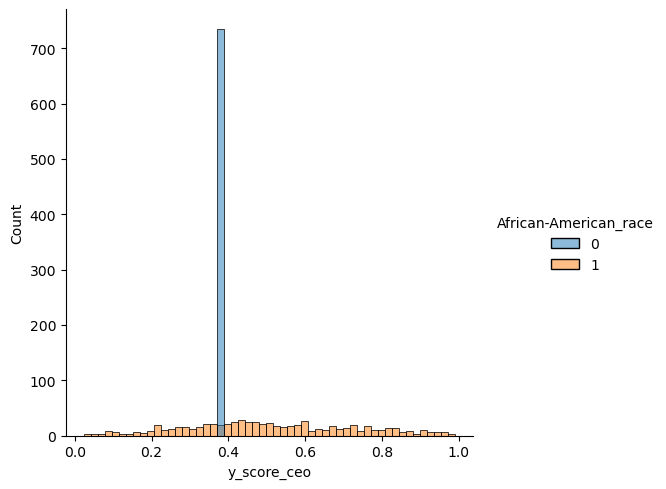

In [21]:
sns.displot(data=test_df, x= 'y_score_ceo',hue= 'African-American_race')

<h3>Reject Option Classification

Reject Option Classification (ROC) is a classification technique in machine learning that allows the classifier to abstain from making a prediction when the confidence in its prediction is low. This is in contrast to traditional classification, where the classifier is forced to make a prediction for every input instance, even if the classifier is uncertain about the true label.


ROC is particularly useful in situations where making an incorrect decision can have significant consequences, such as in medical diagnosis or fraud detection. By allowing the classifier to abstain from making a prediction when it is uncertain, ROC can help to reduce the risk of making errors.

In [17]:
baseline_preprocessed_df['two_year_recid'] = np.where(baseline_preprocessed_df['two_year_recid'] == 1, 0, 1)

y = baseline_preprocessed_df[output_variable]
X = pd.get_dummies(baseline_preprocessed_df.drop(output_variable, axis=1))
data_ = [X, y, group_a, group_b]

dataset = train_test_split(*data_, test_size=0.2, shuffle=True)
train_data = dataset[::2]
test_data = dataset[1::2]


# train
X_train, y_train, group_a_train, group_b_train = train_data
pipeline.fit(X_train, y_train)

# predict train set
y_pred_train = pipeline.predict(X_train)
y_proba_train = pipeline.predict_proba(X_train)

# predict test set
X_test, y_test, group_a_test, group_b_test = test_data
y_pred_test = pipeline.predict(X_test)
y_proba_test = pipeline.predict_proba(X_test)


c:\Users\athar\anaconda3\lib\site-packages\sklearn\utils\validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [18]:
# initialize
roc = RejectOptionClassification(metric_name="Statistical parity difference")

In [19]:
# fit it
roc.fit(y_train, y_proba_train, group_a_train, group_b_train)

In [20]:
# transform it
d = roc.transform(y_test, y_proba_test, group_a_test, group_b_test)
d

{'y_pred': array([ True, False, False, ..., False,  True,  True]),
 'y_score': array([0.7671223 , 0.13091467, 0.36044123, ..., 0.26290264, 0.83871926,
        0.65183229])}

In [21]:
# new predictions
y_pred = d['y_pred']
y_pred

array([ True, False, False, ..., False,  True,  True])

In [22]:
y_pred.shape

(1437,)

In [23]:
# efficacy
metrics_dataframe(y_pred, y_test)

,Value
Metric,
Accuracy,0.698678
Balanced accuracy,0.698137
Precision,0.728362
Recall,0.704897
F1-Score,0.716437


In [24]:
# bias metrics
classification_bias_metrics(group_a_test, group_b_test, y_pred, y_test, metric_type='both')

,Value,Reference
Metric,,
Statistical Parity,-0.066525,0
Disparate Impact,0.880390,1
Four Fifths Rule,0.880390,1
Cohen D,-0.133482,0
2SD Rule,-2.524281,0
Equality of Opportunity Difference,0.002692,0
False Positive Rate Difference,-0.034608,0
Average Odds Difference,-0.015958,0
Accuracy Difference,0.015196,0


In [25]:
y = baseline_preprocessed_df[output_variable]

X = pd.get_dummies(baseline_preprocessed_df.drop(output_variable, axis=1))
data_ = [X, y, group_a, group_b]

Function to find optimal value of range

In [48]:
# Define the boundary values using numpy
# Define the range of low and high threshold values
low_thresholds = np.arange(0.45, 0.24, -0.025)
high_thresholds = np.arange(0.55, 0.76, 0.025)

# Generate pairs of low and high thresholds and round to 2 decimal places
boundaries = [(round(low, 2), round(high, 2)) for low, high in zip(low_thresholds, high_thresholds)]
results = []

In [49]:
for low_thresh, high_thresh in boundaries:
	# Train the model with the current epsilon
	# pipeline = Pipeline(steps=[
    # ('scaler', StandardScaler()),
    # ('classifier', LogisticRegression()),
    # ])

	# pipeline.fit(X_train, y_train)

	# Make predictions
	
	# y_proba = pipeline.predict_proba(X_test)
	# y_score = y_proba[:,1]

	# Initialize and fit the ROC
	roc = RejectOptionClassification(metric_name="Statistical parity difference", low_class_thresh=low_thresh, high_class_thresh=high_thresh)
	roc.fit(y_train, y_proba_train, group_a_train, group_b_train)

	# Transform the test data
	d_roc = roc.transform(y_test, y_proba_test, group_a_test, group_b_test)

	# Compute the fairness metrics
	fairness_metrics_roc = classification_bias_metrics(group_a_test, group_b_test, d_roc['y_pred'], y_test, metric_type='both')
	width = high_thresh - low_thresh
	# Store the results
	results.append({
		# 'epsilon': epsilon,
		'width': width,
		'low_class_thresh': low_thresh,
        'high_class_thresh': high_thresh,
		'accuracy': metrics.accuracy_score(y_test, d_roc['y_pred']),
		'precision': metrics.precision_score(y_test, d_roc['y_pred']),
		'fairness_metrics_roc': fairness_metrics_roc.iloc[6][0]
	})

In [50]:
results

[{'width': 0.10000000000000003,
  'low_class_thresh': 0.45,
  'high_class_thresh': 0.55,
  'accuracy': 0.709116214335421,
  'precision': 0.7708333333333334,
  'fairness_metrics_roc': 0.09330004491294815},
 {'width': 0.15999999999999998,
  'low_class_thresh': 0.42,
  'high_class_thresh': 0.58,
  'accuracy': 0.697981906750174,
  'precision': 0.7823834196891192,
  'fairness_metrics_roc': 0.08560540012152916},
 {'width': 0.19999999999999996,
  'low_class_thresh': 0.4,
  'high_class_thresh': 0.6,
  'accuracy': 0.6917188587334725,
  'precision': 0.7960339943342776,
  'fairness_metrics_roc': 0.08670840928905446},
 {'width': 0.26,
  'low_class_thresh': 0.37,
  'high_class_thresh': 0.63,
  'accuracy': 0.6757132915796799,
  'precision': 0.8,
  'fairness_metrics_roc': 0.08330691395207523},
 {'width': 0.30000000000000004,
  'low_class_thresh': 0.35,
  'high_class_thresh': 0.65,
  'accuracy': 0.6680584551148225,
  'precision': 0.8027681660899654,
  'fairness_metrics_roc': 0.08419856806953582},
 {'w

In [51]:
data = pd.DataFrame(results)
data

,width,low_class_thresh,high_class_thresh,accuracy,precision,fairness_metrics_roc
0,0.10,0.45,0.55,0.709116,0.770833,0.093300
1,0.16,0.42,0.58,0.697982,0.782383,0.085605
2,0.20,0.40,0.60,0.691719,0.796034,0.086708
3,0.26,0.37,0.63,0.675713,0.800000,0.083307
4,0.30,0.35,0.65,0.668058,0.802768,0.084199
5,0.36,0.32,0.68,0.665971,0.838583,0.058017
6,0.40,0.30,0.70,0.659708,0.855895,0.044926
7,0.46,0.27,0.73,0.647878,0.880208,0.041525
8,0.50,0.25,0.75,0.640223,0.890173,0.029794


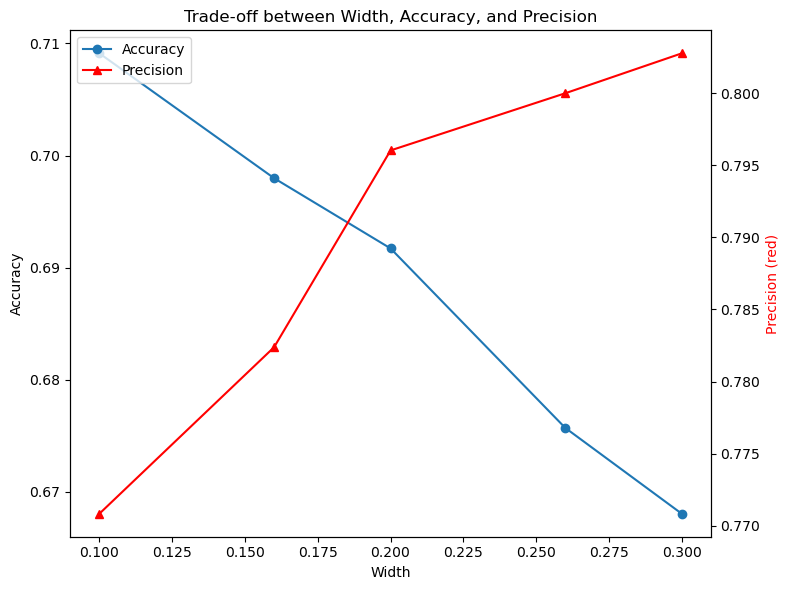

In [42]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot accuracy vs width
ax1.plot(data["width"], data["accuracy"], marker="o", linestyle="-", label="Accuracy")

# Add a second axis for precision
ax2 = ax1.twinx()
ax2.plot(data["width"], data["precision"], marker="^", linestyle="-", color="red", label="Precision")

# Set labels and title
ax1.set_xlabel("Width")
ax1.set_ylabel("Accuracy")
ax2.set_ylabel("Precision (red)", color="red")
plt.title("Trade-off between Width, Accuracy, and Precision")

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

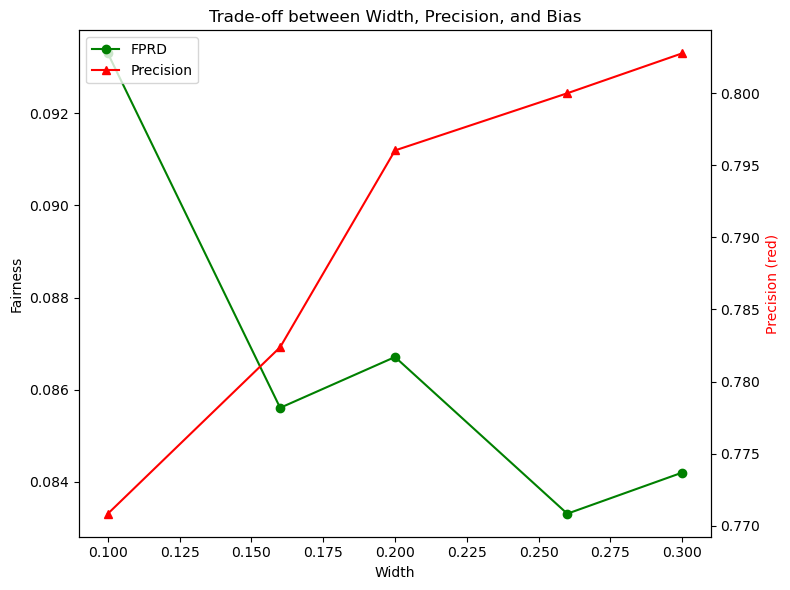

In [44]:
# Create the plot
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot Fairness vs width
ax1.plot(data["width"], data["fairness_metrics_roc"], marker="o",  color="green",linestyle="-", label="FPRD")

# Add a second axis for precision
ax2 = ax1.twinx()
ax2.plot(data["width"], data["precision"], marker="^", linestyle="-", color="red", label="Precision")

# Set labels and title
ax1.set_xlabel("Width")
ax1.set_ylabel("Fairness")
ax2.set_ylabel("Precision (red)", color="red")
plt.title("Trade-off between Width, Precision, and Bias")

# Add legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

To get the fairness significantly below 0.08, 0.36 width offering fairness of 0.045 seems perfect in terms of fairness , accuracy and Precision. 
we take this value as it acheives 83% precision, but after implementing DP, it is expected to come down to 80%